In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

L'annonce par l'Angleterre, le 21 septembre 1931, de la fin de la convertibilité en or de la Livre Sterling marque une étape importante de la crise économique de l'entre-deux guerre. En effet, cette annonce est d'autant plus un coup de tonnerre qu'il s'agit d'une monnaie qui joue un rôle prépondérant dans le système monétaire international, qui s'éffondre donc brutalement, même si d'autres monnaies, le Dollar et le Franc notamment, jouent aussi un role important. De fait, comment s'organise ce système monnétaire international ? Comment expliquer que certains pays choisissent d'avoir recours à la monnaie d'un autre pays, c'est à dire d'échanger celle-ci sur un marché des changes domestique ? 

L'objectif de ce travail est d'analyser l'organisation des liens monétaires entre les principales économies mondiales au tournant des 19ème et 20ème siècles. Pour cela, nous nous appuierons sur la base de données mise à disposition par Flandreau et Jobst à partir de laquelle nous construirons une analyse de réseau.

### Présentation des données

In [4]:
# Lecture des données
data = pd.read_csv('data/flandreau_jobst_internationalcurrencies_data.txt', encoding='cp1252', skiprows=9, header=0, sep='\t')

In [5]:
# Commençons par créer un fichier attributes en ne gardant que les éléments par pays puis supprimant les lignes qui se répètent
attributes = data[["country_A", "gold", "colony", "debtburden", "rlong", "rshort1900", "rshort1890", "rgdp", "rgdpcap", "poldemo", "coverage"]]
# Sort the dataframe to ensure rows with colony=1 come first
attributes = attributes.sort_values(by=["country_A", "colony"], ascending=[True, False])
# Drop duplicates, keeping the first row (colony=1 will be kept if present)
attributes = attributes.drop_duplicates(subset="country_A", keep="first").reset_index(drop=True)
attributes = attributes.rename(columns={"colony": "is_colonized"})

# Récupérons aussi le nombre de colonies
nb_colonies = data.groupby("country_B")["colony"].sum().reset_index()
nb_colonies = nb_colonies.rename(columns={"colony": "has_colonies"})
attributes = nb_colonies.merge(attributes, left_on="country_B", right_on="country_A", how="left")
attributes = attributes.drop(columns=['country_A'])
attributes = attributes.rename(columns={"country_B": "country"})

In [6]:
country_mapping = {
    "ARG": "Argentina",
    "AUS": "Australia",
    "AUH": "United Arab Emirates",
    "BEL": "Belgium",
    "BRA": "Brazil",
    "CAN": "Canada",
    "CEY": "Ceylon",
    "CHE": "Switzerland",
    "CHL": "Chile",
    "CHN": "China",
    "COL": "Colombia",
    "CUB": "Cuba",
    "DEU": "Germany",
    "DNK": "Denmark",
    "ECU": "Ecuador",
    "EGY": "Egypt",
    "ESP": "Spain",
    "FIN": "Finland",
    "FRA": "France",
    "GBR": "United Kingdom",
    "GRC": "Greece",
    "HKG": "Hong Kong",
    "ICH": "Sandwich Islands",
    "IND": "India",
    "ITA": "Italy",
    "JAV": "Java",
    "JPN": "Japan",
    "MEX": "Mexico",
    "NLD": "Netherlands",
    "NOR": "Norway",
    "NZL": "New Zealand",
    "OTT": "Ottoman Empire",
    "PER": "Peru",
    "PHL": "Philippines",
    "PRT": "Portugal",
    "PRS": "Persia",
    "ROM": "Romania",
    "RUS": "Russia",
    "SER": "Serbia",
    "SGP": "Singapore",
    "SIA": "Siam",
    "SWE": "Sweden",
    "URY": "Uruguay",
    "USA": "United States",
    "VEN": "Venezuela"}

attributes["country"] = attributes["country"].map(country_mapping)

Les données mobilisées concernent 45 pays. La majorité des pays européens de l'époque sont représentés, de même qu'un certain nombre de pays asiatiques, ou sur le continent américain, et toutes les économies les plus développées sont présentes (voir liste des pays en Annexe (?)). On notera cependant l'absence de tout pays du continent africain.
Les données sont structurées sous la forme d'une edgelist développée : pour chacuns des 1980 liens (orientés) possibles entre deux pays, nous disposons d'informations sur la présence d'un marché des changes dans le pays A échangeant la monnaie du pays B à trois dates différentes (1890, 1900 et 1910), ainsi que des informations sur un lien colonial, et sur le commerce billatéral. A cela s'ajoute un certain nombre d'informations sur chaque pays (induisant donc une redondance des informations dans le dataset) dont la liste est présentée en Annexe (??)

Nous faisons le choix ici de nous concentrer sur les liens entre les pays en 1900, et de définir notre réseau ainsi : **nous considérons qu'il y a un lien du pays A vers le pays B si le pays A dispose d'un marché des changes échangeant la monnaie du pays B** (autrement dit, la monnaie du pays B circule au sein du pays A) et nous reconstituons un fichier d'attributs en réorganisant les données du dataset. Le choix de l'années 1900 s'explique car il s'agit de l'année pour laquelle les données d'attribut disponibles sont les plus nombreuses.

Les données ont été réunies par Marc Flandreau et Clemens Jobst, lesquels en ont tiré deux articles (2005 et 2009), qui documentent la construction du dataset. Celle-ci permet d'expliquer partiellement l'absence de pays africain : les auteurs ne sont sans doute pas parvenu à réunir des informations suffisantes sur l'existence de marchés locaux échangeant des titres labellisés en monnaie européenne.

In [8]:
attributes.style.hide(axis="index")

country,has_colonies,gold,is_colonized,debtburden,rlong,rshort1900,rshort1890,rgdp,rgdpcap,poldemo,coverage
Argentina,0,1,0,6.844985,7.010000,7.060000,9.330000,16.375360,7.921540,0.300000,1.945910
United Arab Emirates,0,1,0,5.222065,4.010000,4.580000,4.480000,18.143680,7.393880,0.870000,1.791759
Australia,0,1,1,6.065920,3.120000,5.500000,7.000000,16.524400,8.297290,6.370000,0.000000
Belgium,0,1,0,4.882136,3.150000,4.090000,3.180000,17.029210,8.224430,10.660000,2.079442
Brazil,0,0,0,5.516892,6.970000,9.200000,6.300000,16.316390,6.519150,0.220000,1.791759
Canada,0,1,1,6.784091,3.610000,6.500000,6.500000,16.580910,7.976250,8.580000,0.693147
Ceylon,0,1,1,1.362319,3.250000,nan,nan,15.434200,7.162400,0.000000,1.098612
Switzerland,0,1,0,0.910000,3.080000,4.290000,3.890000,16.353080,8.251400,5.600000,1.945910
Chile,0,0,0,2.939891,5.600000,7.000000,8.100000,15.572730,7.575070,1.780000,1.098612
China,0,0,0,4.340557,6.100000,6.000000,7.000000,19.200010,6.300790,0.000000,1.791759


### Première description du graph

In [9]:
# Création d'un graph orienté avec la variable 1900
graph_change_1900 = nx.DiGraph()

for _, row in data.iterrows():
    if row["quote1900"] == 1:
        graph_change_1900.add_edge(row["country_A"], row["country_B"])

In [15]:
n = graph_change_1900.number_of_nodes()
L = graph_change_1900.number_of_edges()
density = L/(n*(n-1))
print(f"Nombre de sommets : {n}")
print(f"Nombre d'arêtes : {L}")
print(f"Densité : {density:.4f}")

no_incoming = [node for node in graph_change_1900.nodes() if graph_change_1900.in_degree(node) == 0]
no_incoming_share = len(no_incoming) / n if n > 0 else 0
print(f"Proportion de pays  sans lien entrant : {100*no_incoming_share:.1f} %")

bidir_edges = sum(1 for u, v in graph_change_1900.edges() if graph_change_1900.has_edge(v, u))
total_edges = graph_change_1900.number_of_edges()
unidir_edges = total_edges - bidir_edges
country_links = unidir_edges + (bidir_edges / 2)
bidir_share = (bidir_edges / 2) / country_links
print(f"Proportion de liens réciproques : {100*bidir_share:.1f} %")

Nombre de sommets : 45
Nombre d'arêtes : 218
Densité : 0.1101
Proportion de pays  sans lien entrant : 44.4 %
Proportion de liens réciproques : 27.5 %


Notre graph est donc un graph orienté connexe de 45 sommets, ne contenant aucun isolé. Il apparait ainsi que, du moins pour les pays considérés, le marché des changes était relativement intégré puisqu'il est possible, depuis n'importe quel pays, de trouver une monnaie commune pour échanger avec n'importe quel autre pays. Nous pouvons voir néanmoins qu'il possède une densité relativement faible, de 11 % environ (en effet, avec 218 arrête sur les 1980 possibles, seul un peu plus de 10 % des arrêtes possibles existent réellement). Cependant, remarquons qu'une situation de domination monétaire totale, dans laquelle un pays imposerait sa monnaie à tous les autres, permettrait des échanges bilattéraux entre tous les pays en ne nécessitant que 44 arrêtes, ce qui montre un certain polycentrisme monétaire. 
Enfin, près de la moitié des pays renseignés (44,4 %) ont une monnaie qui ne circule pas hors de leurs frontières nationales. Par ailleurs, un lien entre deux pays n'est réciproque que dans un peu plus d'un quart des cas.

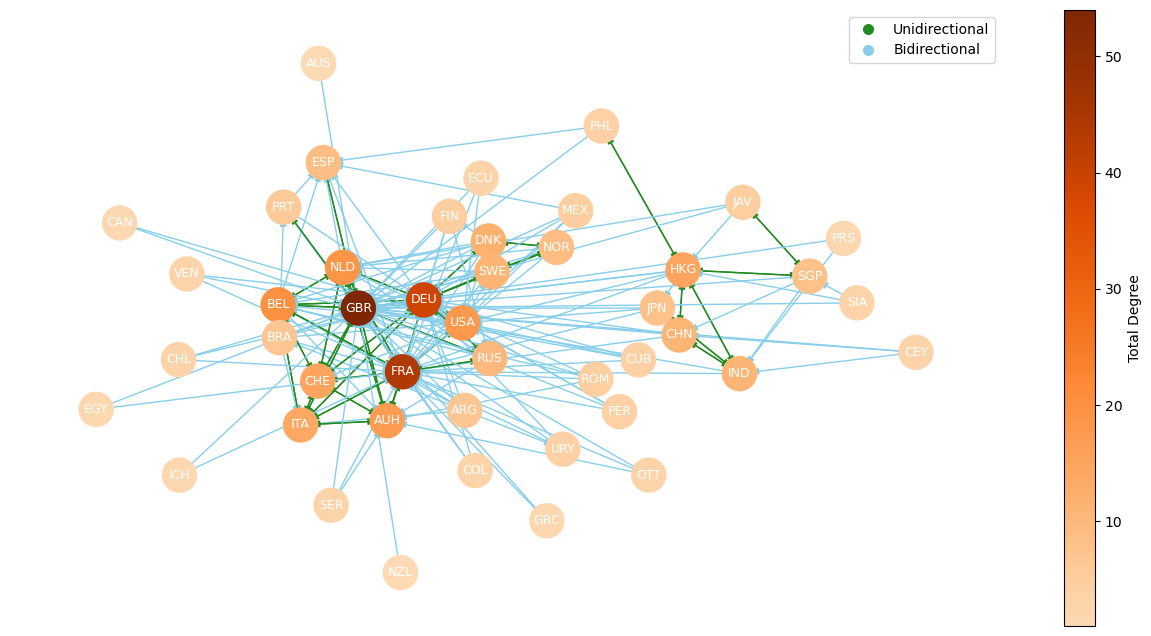

In [16]:
def truncate_colormap(cmap_name, min_val=0.2, max_val=1.0, n=100):
    cmap = plt.get_cmap(cmap_name)
    new_cmap = LinearSegmentedColormap.from_list(
        f"{cmap_name}_trunc", cmap(np.linspace(min_val, max_val, n))
    )
    return new_cmap

trunc_oranges = truncate_colormap("Oranges", 0.2, 1.0)

# Determine edge colors
edge_colors = []
for u, v in graph_change_1900.edges():
    if graph_change_1900.has_edge(v, u):
        edge_colors.append("forestgreen")  # reciprocal
    else:
        edge_colors.append("skyblue")  # unidirectional

# Compute node colors based on total degree (in-degree + out-degree)
degrees = dict(graph_change_1900.degree())
node_colors = [degrees[node] for node in graph_change_1900.nodes()]

# Draw graph
plt.figure(figsize=(16, 8))
pos = nx.spring_layout(graph_change_1900, seed=43)

nodes = nx.draw_networkx_nodes(
    graph_change_1900,
    pos,
    node_size=600,
    node_color=node_colors,
    cmap=trunc_oranges)

edges = nx.draw_networkx_edges(
    graph_change_1900,
    pos,
    edge_color=edge_colors)

labels = nx.draw_networkx_labels(graph_change_1900, pos, font_size=9, font_color="white")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='forestgreen', markersize=9, label='Unidirectional'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='skyblue', markersize=9, label='Bidirectional')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.colorbar(nodes, label="Total Degree")
plt.axis("off")
plt.show()

La représentation graphique fait ressortir un marché très intégré en Europe (à laquelle s'ajoute les Etats-unis), autours de la Grande-Bretagne, de la France et de l'Allemagne, autourne duquel gravite de nombreux pays, plutôt en Asie, en Amérique ou aux marges de l'Europe, caractérisés par une absence de liens entrants et un nombre limités de liens sortants. Un pôle secondaire se dessine néanmoins en Asie Orientale, avec quelques liens bilatéraux et une plus grande densité autours de Hong-Kong, l'Inde ou la Chine. La séparation entre ces deux pôles est d'ailleurs très nette lorsque l'on se limite au graphique des liens billatéraux, puisque deux réseaux disjoints apparaissent alors, l'un en Asie et l'autre en Europe plus Etats-Unis.

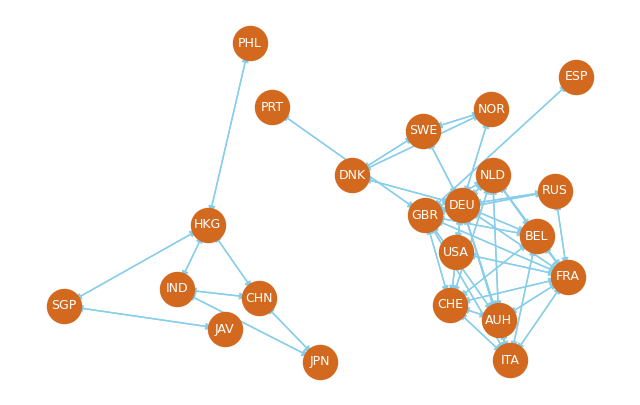

In [17]:
graph_change_1900 = nx.DiGraph()

for _, row in data.iterrows():
    if row["quote1900"] == 1:
        graph_change_1900.add_edge(row["country_A"], row["country_B"])

# Filter for reciprocal edges
reciprocal_edges = [(u, v) for u, v in graph_change_1900.edges() if graph_change_1900.has_edge(v, u)]
# Get nodes involved in reciprocal edges
nodes_with_reciprocal_edges = set(u for u, v in reciprocal_edges) | set(v for u, v in reciprocal_edges)

plt.figure(figsize=(8, 5))
pos = nx.spring_layout(graph_change_1900, seed=42)
graph_filtered = graph_change_1900.subgraph(nodes_with_reciprocal_edges)

nx.draw_networkx_nodes(graph_filtered, pos, node_size=600, node_color="chocolate")
nx.draw_networkx_edges(graph_filtered, pos, edgelist=reciprocal_edges, edge_color="skyblue")
nx.draw_networkx_labels(graph_filtered, pos, font_size=9, font_color="white")

plt.axis("off")
plt.show()

In [23]:
out_degree = graph_change_1900.out_degree()
in_degree = graph_change_1900.in_degree()

out_degree_centrality = nx.out_degree_centrality(graph_change_1900)
in_degree_centrality = nx.in_degree_centrality(graph_change_1900)
betweenness_centrality = nx.betweenness_centrality(graph_change_1900)
eigenvector_centrality = nx.eigenvector_centrality(graph_change_1900)

df = pd.DataFrame({
    "Country": [node for node, _ in out_degree],
    "Out-Degree": [degree for _, degree in out_degree],
    "In-Degree": [degree for _, degree in in_degree],
    "Out-Degree Centrality": [out_degree_centrality.get(node, 0) for node, _ in out_degree],
    "In-Degree Centrality": [in_degree_centrality.get(node, 0) for node, _ in in_degree],
    "Betweenness Centrality": [betweenness_centrality.get(node, 0) for node, _ in out_degree],
    "Eigenvector Centrality": [eigenvector_centrality.get(node, 0) for node, _ in out_degree]
})

df["In / Out ratio"] = df["In-Degree Centrality"] / df["Out-Degree Centrality"]
df = df[[*df.columns[:df.columns.get_loc("In-Degree Centrality")+1], *df.columns[df.columns.get_loc("In-Degree Centrality")+1:].drop("In / Out ratio")]]

df_sorted = df.sort_values(by="In-Degree", ascending=False)
df_sorted.style.hide(axis="index").format({
    "Out-Degree": "{:.0f}",
    "In-Degree": "{:.0f}",
    "Out-Degree Centrality": "{:.3f}",
    "In-Degree Centrality": "{:.3f}",
    "Betweenness Centrality": "{:.3f}",
    "Average Centrality": "{:.3f}",
    "Eigenvector Centrality": "{:.3f}",
})

Country,Out-Degree,In-Degree,Out-Degree Centrality,In-Degree Centrality,Betweenness Centrality,Eigenvector Centrality
GBR,10,44,0.227,1.000,0.115,0.386
FRA,9,35,0.205,0.795,0.046,0.386
DEU,13,26,0.295,0.591,0.104,0.365
NLD,7,12,0.159,0.273,0.004,0.328
BEL,8,12,0.182,0.273,0.003,0.314
AUH,6,11,0.136,0.250,0.003,0.323
USA,7,11,0.159,0.250,0.012,0.105
CHE,7,8,0.159,0.182,0.000,0.318
ITA,6,8,0.136,0.182,0.001,0.269
ESP,2,7,0.045,0.159,0.000,0.185


Les différentes mesures de centralités permettent de quantifier l'importance relative des différents sommets. Lorsque l'on s'intéresse tout d'abord au degré, il apparait que le degré entrant est beaucoup plus concentré que le degré sortant. Or, comme l'explique Flandreau et Jobst (2005), il s'agit du plus pertinent ici. En effet, il marque la capacité d'un pays à imposer l'usage de sa monnaie à un nombre important de pays. De ce point de vue, la Grande-Bretagne se distingue très nétemment puisque son degré de centralité entrante vaut 1 : tous les pays du réseau ont un lien sortant vers elle. Néanmoins, la France est très proche (avec 79,5 % des pays ayant un lien sortant vers elle), ainsi que l'Allemagne un peu plus loin (59,1 %). A l'opposé, 19 pays ont un degré sortant de zéro.

La centralité vectorielle permet de tenir compte du fait que tous les liens, dans un réseau, ne sont pas équivalents. En effet, un lien a plus de "valeur" s'il relie à un sommet lui-même fortement intégré au réseau. Cet indicateur fait clairement apparaître l'existence d'un "coeur" fortement intégré, autours des trois pays précédemment cités, mais avec d'autres pays, très proches, dont les degrés sont plus faibles mais qui profitent de leur très forte intégration dans ce réseau d'Europe Occidentale pour voir leur centralité vectorielle augmenter fortement, comme les Pays-Bas, la Belgique ou la Suisse. Les Etats-Unis affichent de leur côté une centralité vectorielle relativement faible, ce qui s'explique par le fait que, s'ils ont des liens avec les principaux centres européens, ils ne sont pas pleinement intégrés à ce réseau au profit de liens avec des pays d'Asie ou d'Amérique, eux-mêmes peu intégrés, contrairement à l'Autriche-Hongrie qui présente le même nombre de liens (et même un lien sortant de moins) pour une centralité vectorielle trois plus élevée. Enfin, les pays d'Asie orientale, pourtant intégrés entre eux, sont relégués trop loins des principaux centres ce qui aboutit à une centralité vectorielle nulle (cas deHong-Kong, ou de l'Inde).

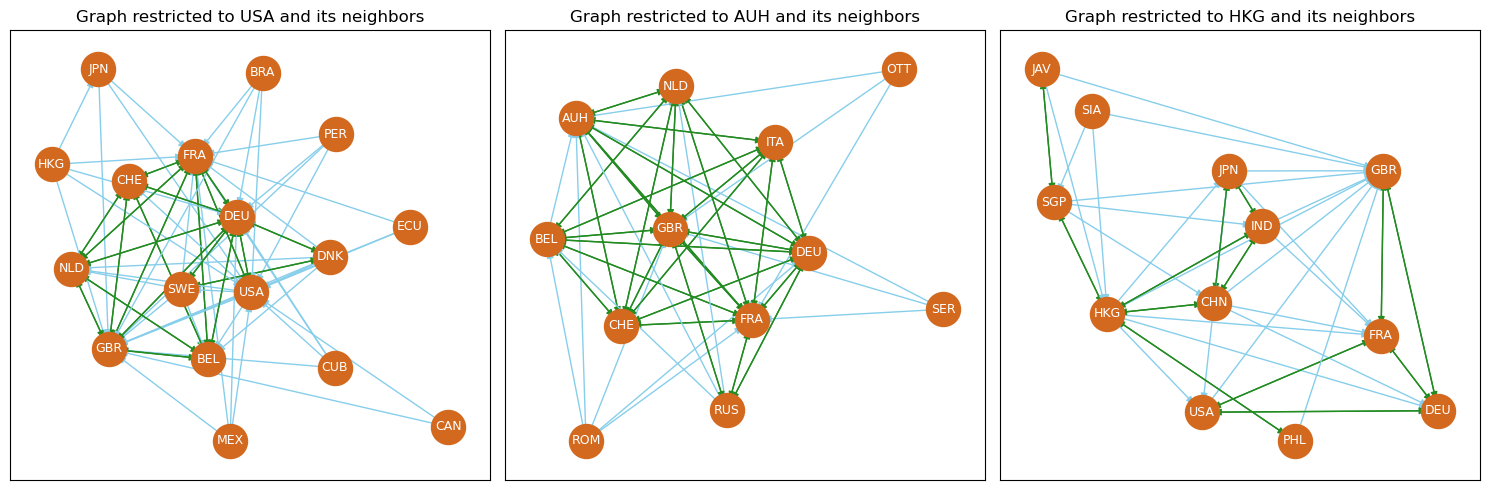

In [32]:
countries = ["USA", "AUH", "HKG"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, country_B in enumerate(countries):
    # Get the nodes related to country_B
    neighbors = list(graph_change_1900.neighbors(country_B))
    predecessors = list(graph_change_1900.predecessors(country_B))
    nodes_involved = [country_B] + neighbors + predecessors
    subgraph = graph_change_1900.subgraph(nodes_involved)
    restricted_graph = nx.DiGraph(subgraph)

    edge_colors = []
    for u, v in restricted_graph.edges():
        if restricted_graph.has_edge(v, u):
            edge_colors.append("forestgreen")  # reciprocal
        else:
            edge_colors.append("skyblue")  # unidirectional

    pos = nx.spring_layout(restricted_graph, seed=100)
    ax = axes[i]
    nx.draw_networkx_nodes(restricted_graph, pos, node_size=600, node_color="chocolate", ax=ax)
    nx.draw_networkx_edges(restricted_graph, pos, edge_color=edge_colors, ax=ax)
    nx.draw_networkx_labels(restricted_graph, pos, font_size=9, font_color="white", ax=ax)
    ax.set_title(f"Graph restricted to {country_B} and its neighbors")

plt.tight_layout()
plt.show()